In [4]:
import numpy as np
import matplotlib.pyplot as plt 
from keras.models import load_model
from matplotlib import cm

def loadArray(case,field):
    data = np.load('/home/haoyan/Desktop/ML-CFD/dataset/archive/'+dataset+'/'+dataset+'_'+case+'_'+field + '.npy')
    return data

def loadLabels(case,field):
    data = np.load('/home/haoyan/Desktop/ML-CFD/dataset/archive/'+'labels/'+case+'_'+field + '.npy')
    return data

def make_realizable(label):
        """
        This function is specific to turbulence modeling.
        Given the anisotropy tensor, this function forces realizability
        by shifting values within acceptable ranges for Aii > -1/3 and 2|Aij| < Aii + Ajj + 2/3
        Then, if eigenvalues negative, shifts them to zero. Noteworthy that this step can undo
        constraints from first step, so this function should be called iteratively to get convergence
        to a realizable state.
        :param labels: the predicted anisotropy tensor (num_points X 9 array)
        """
        numPoints = label.shape[0]
        labels = np.zeros((numPoints,9))
        for i in range(numPoints):
            labels[i][0] = label[i][0]
            labels[i][1] = label[i][1]
            labels[i][2] = label[i][2]
            labels[i][3] = label[i][1]
            labels[i][4] = label[i][3]
            labels[i][5] = label[i][4]
            labels[i][6] = label[i][2]
            labels[i][7] = label[i][4]
            labels[i][8] = label[i][5]
        A = np.zeros((3, 3))
        for i in range(numPoints):
            # Scales all on-diags to retain zero trace
            if np.min(labels[i, [0, 4, 8]]) < -1./3.:
                labels[i, [0, 4, 8]] *= -1./(3.*np.min(labels[i, [0, 4, 8]]))
            if 2.*np.abs(labels[i, 1]) > labels[i, 0] + labels[i, 4] + 2./3.:
                labels[i, 1] = (labels[i, 0] + labels[i, 4] + 2./3.)*.5*np.sign(labels[i, 1])
                labels[i, 3] = (labels[i, 0] + labels[i, 4] + 2./3.)*.5*np.sign(labels[i, 1])
            if 2.*np.abs(labels[i, 5]) > labels[i, 4] + labels[i, 8] + 2./3.:
                labels[i, 5] = (labels[i, 4] + labels[i, 8] + 2./3.)*.5*np.sign(labels[i, 5])
                labels[i, 7] = (labels[i, 4] + labels[i, 8] + 2./3.)*.5*np.sign(labels[i, 5])
            if 2.*np.abs(labels[i, 2]) > labels[i, 0] + labels[i, 8] + 2./3.:
                labels[i, 2] = (labels[i, 0] + labels[i, 8] + 2./3.)*.5*np.sign(labels[i, 2])
                labels[i, 6] = (labels[i, 0] + labels[i, 8] + 2./3.)*.5*np.sign(labels[i, 2])

            # Enforce positive semidefinite by pushing evalues to non-negative
            A[0, 0] = labels[i, 0]
            A[1, 1] = labels[i, 4]
            A[2, 2] = labels[i, 8]
            A[0, 1] = labels[i, 1]
            A[1, 0] = labels[i, 1]
            A[1, 2] = labels[i, 5]
            A[2, 1] = labels[i, 5]
            A[0, 2] = labels[i, 2]
            A[2, 0] = labels[i, 2]
            evalues, evectors = np.linalg.eig(A)
            if np.max(evalues) < (3.*np.abs(np.sort(evalues)[1])-np.sort(evalues)[1])/2.:
                evalues = evalues*(3.*np.abs(np.sort(evalues)[1])-np.sort(evalues)[1])/(2.*np.max(evalues))
                A = np.dot(np.dot(evectors, np.diag(evalues)), np.linalg.inv(evectors))
                for j in range(3):
                    labels[i, j] = A[j, j]
                labels[i, 1] = A[0, 1]
                labels[i, 5] = A[1, 2]
                labels[i, 2] = A[0, 2]
                labels[i, 3] = A[0, 1]
                labels[i, 7] = A[1, 2]
                labels[i, 6] = A[0, 2]
            if np.max(evalues) > 1./3. - np.sort(evalues)[1]:
                evalues = evalues*(1./3. - np.sort(evalues)[1])/np.max(evalues)
                A = np.dot(np.dot(evectors, np.diag(evalues)), np.linalg.inv(evectors))
                for j in range(3):
                    labels[i, j] = A[j, j]
                labels[i, 1] = A[0, 1]
                labels[i, 5] = A[1, 2]
                labels[i, 2] = A[0, 2]
                labels[i, 3] = A[0, 1]
                labels[i, 7] = A[1, 2]
                labels[i, 6] = A[0, 2]
                
        labels_6 = np.zeros((numPoints,6))
        for i in range(numPoints):
            labels_6[i][0] = labels[i][0]
            labels_6[i][1] = labels[i][1]
            labels_6[i][2] = labels[i][2]
            labels_6[i][3] = labels[i][4]
            labels_6[i][4] = labels[i][5]
            labels_6[i][5] = labels[i][8]
        return labels_6

dataset = 'komega'
case = 'CNDV_12600'

In [5]:
x = loadArray(case,'Cx')
y = loadArray(case,'Cy')
z = loadArray(case,'Cz')
b = loadLabels(case,'b')
Scalars = loadArray(case,'q')
Tensors = loadArray(case,'Tensors')
Invariants = loadArray(case,'I')
Features = np.column_stack((Invariants,Scalars))

In [6]:
model = load_model("/home/haoyan/Desktop/ML-CFD/case.h5")

In [7]:
b_p = model.predict([Features,Tensors])

2022-06-24 17:15:59.220204: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20134800 exceeds 10% of free system memory.
2022-06-24 17:15:59.265837: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 35532000 exceeds 10% of free system memory.


In [8]:
b_p = make_realizable(b_p)
bij_field = ''
for i in range(len(b_p)):
    bij_field += f'({b_p[i][0]} {b_p[i][1]} {b_p[i][2]} {b_p[i][3]} {b_p[i][4]} {b_p[i][5]})\n'

In [9]:
file_template = f'''/*--------------------------------*- C++ -*----------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  v2012                                 |
|   \\  /    A nd           | Website:  www.openfoam.com                      |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{{
    version     2.0;
    format      ascii;
    class       volSymmTensorField;
    location    "0";
    object      bij;
}}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //
dimensions      [0 0 0 0 0 0 0];
internalField   nonuniform List<symmTensor> 
{b_p.shape[0]}
(
{bij_field}
)
;
boundaryField
{{
    inlet
    {{
        type            zeroGradient;
    }}
    outlet
    {{
        type            zeroGradient;
    }}
    bottom
    {{
        type            fixedValue;
        value           uniform (0 0 0 0 0 0);
    }}
    top
    {{
        type            fixedValue;
        value           uniform (0 0 0 0 0 0);
    }}
    frontAndBack
    {{
        type            empty;
    }}
}}
// ************************************************************************* //'''

# Saving b_ij as a text file
with open('bij_ling', 'w') as file:
    file.write(file_template)

/home/haoyan/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


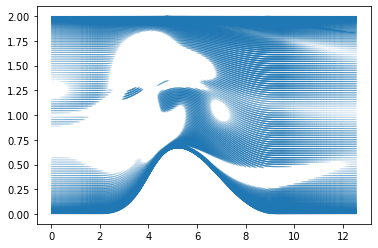

In [10]:
plt.scatter(x,y,b_p[:,0])